In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random

device = torch.device("cpu")

In [2]:
class ArabicSignDataset(Dataset):
    def __init__(self, base_path, transform=None):
        self.img_dir = os.path.join(base_path, 'images')
        self.label_dir = os.path.join(base_path, 'labels')
        self.transform = transform
        all_imgs = sorted([f for f in os.listdir(self.img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.valid_imgs = [img for img in all_imgs if os.path.exists(os.path.join(self.label_dir, img.rsplit('.', 1)[0] + '.txt'))]
        random.shuffle(self.valid_imgs)

    def __len__(self):
        return len(self.valid_imgs)

    def __getitem__(self, idx):
        img_name = self.valid_imgs[idx]
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('L')
        w, h = image.size
        with open(os.path.join(self.label_dir, img_name.rsplit('.', 1)[0] + '.txt'), 'r') as f:
            line = f.readline().split()
            label = int(line[0])
            cx, cy, bw, bh = float(line[1]), float(line[2]), float(line[3]), float(line[4])
            left, top = (cx - bw/2) * w, (cy - bh/2) * h
            right, bottom = (cx + bw/2) * w, (cy + bh/2) * h
            image = image.crop((max(0, left), max(0, top), min(w, right), min(h, bottom)))
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = ArabicSignDataset('Data Set/train', transform=train_transform)
val_set = ArabicSignDataset('Data Set/valid', transform=val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

In [3]:
class ArSLModel(nn.Module):
    def __init__(self, num_classes=28):
        super(ArSLModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

model = ArSLModel(num_classes=28).to(device)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

def run_training(epochs=15):
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        t_loss, t_correct, t_total = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            _, pred = out.max(1)
            t_total += labels.size(0)
            t_correct += pred.eq(labels).sum().item()
            
        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                loss = criterion(out, labels)
                v_loss += loss.item()
                _, pred = out.max(1)
                v_total += labels.size(0)
                v_correct += pred.eq(labels).sum().item()
        
        history['train_acc'].append(100. * t_correct / t_total)
        history['train_loss'].append(t_loss / len(train_loader))
        history['val_acc'].append(100. * v_correct / v_total)
        history['val_loss'].append(v_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}: Train {history['train_acc'][-1]:.2f}% | Val {history['val_acc'][-1]:.2f}%")
    return history

history = run_training(epochs=20)

Epoch 1: Train 6.73% | Val 11.49%
Epoch 2: Train 18.17% | Val 42.30%
Epoch 3: Train 33.82% | Val 60.00%
Epoch 4: Train 45.24% | Val 65.40%
Epoch 5: Train 53.43% | Val 71.03%
Epoch 6: Train 57.45% | Val 80.92%
Epoch 7: Train 61.54% | Val 86.09%
Epoch 8: Train 66.01% | Val 87.01%
Epoch 9: Train 67.40% | Val 87.82%
Epoch 10: Train 69.55% | Val 88.62%
Epoch 11: Train 70.97% | Val 90.57%
Epoch 12: Train 72.35% | Val 88.51%
Epoch 13: Train 71.27% | Val 90.00%
Epoch 14: Train 74.69% | Val 92.18%
Epoch 15: Train 74.48% | Val 91.03%
Epoch 16: Train 75.40% | Val 93.68%
Epoch 17: Train 77.27% | Val 93.45%
Epoch 18: Train 76.56% | Val 94.02%
Epoch 19: Train 78.07% | Val 95.52%
Epoch 20: Train 78.26% | Val 95.29%


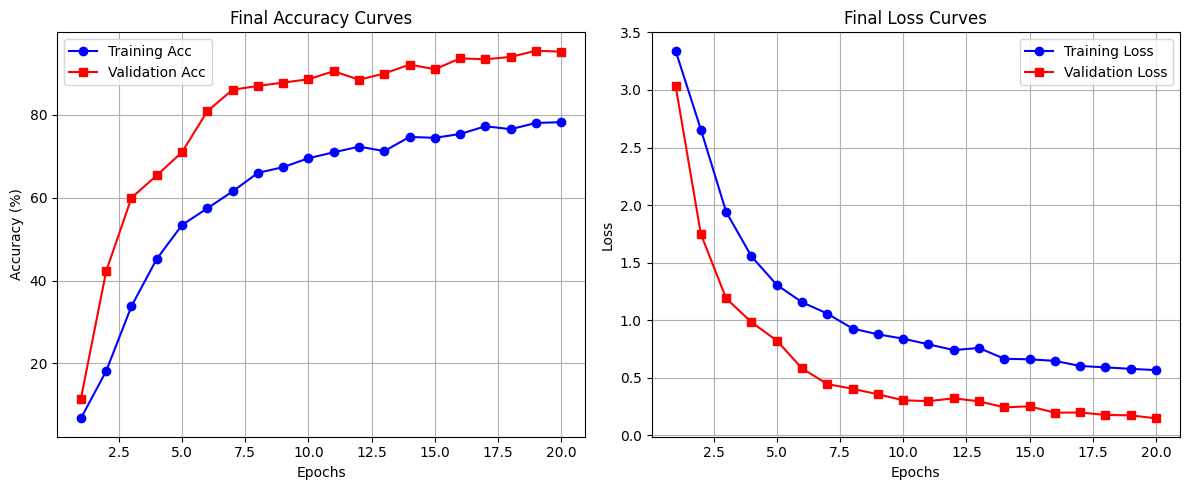

In [5]:
import matplotlib.pyplot as plt

def plot_final_results(history):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 5))
    
    # Accuracy Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-s', label='Validation Acc')
    plt.title('Final Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Loss Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss')
    plt.title('Final Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_final_results(history)

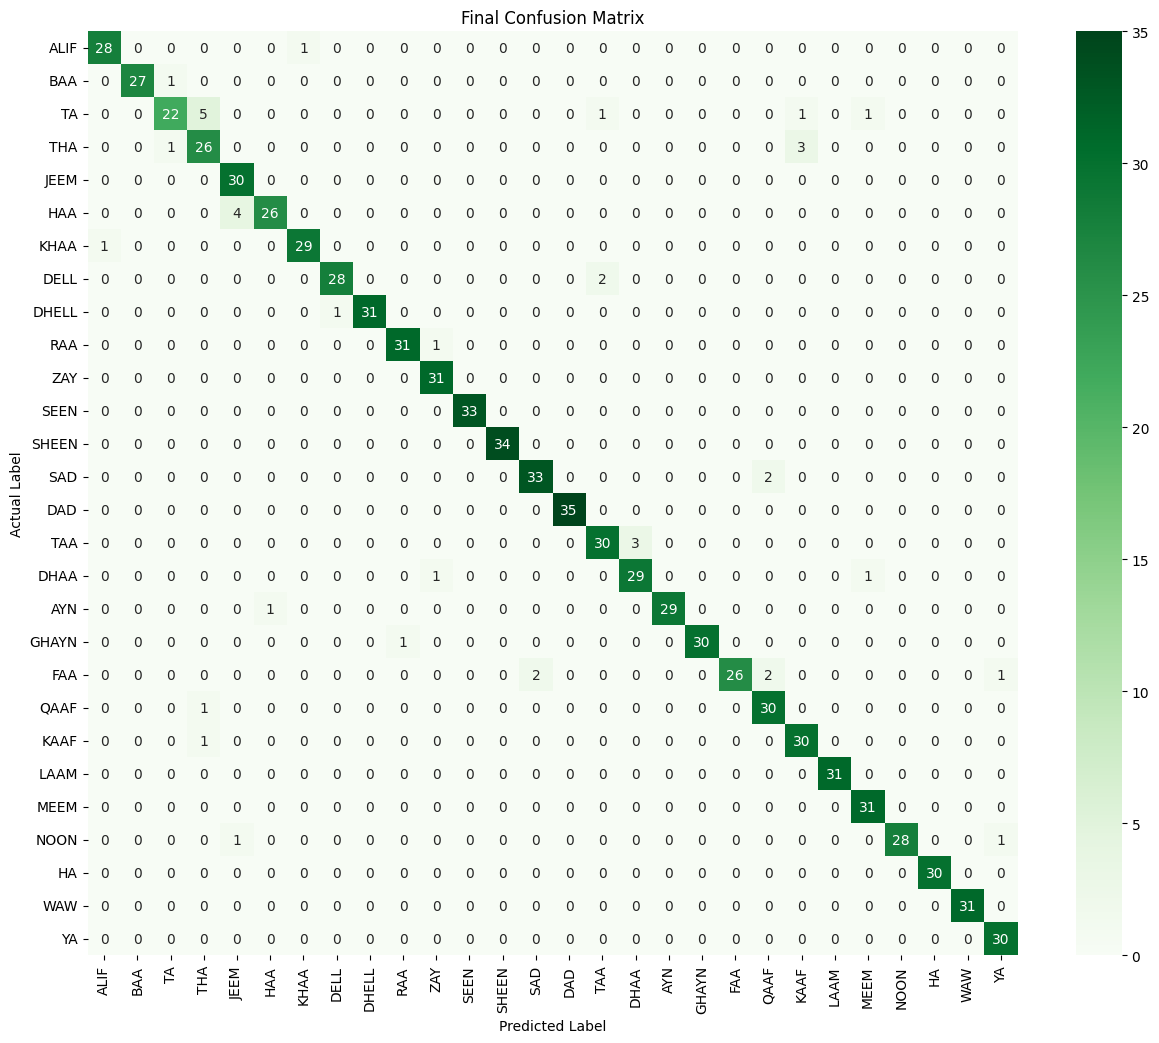


Detailed Classification Report:

              precision    recall  f1-score   support

        ALIF       0.97      0.97      0.97        29
         BAA       1.00      0.96      0.98        28
          TA       0.92      0.73      0.81        30
         THA       0.79      0.87      0.83        30
        JEEM       0.86      1.00      0.92        30
         HAA       0.96      0.87      0.91        30
        KHAA       0.97      0.97      0.97        30
        DELL       0.97      0.93      0.95        30
       DHELL       1.00      0.97      0.98        32
         RAA       0.97      0.97      0.97        32
         ZAY       0.94      1.00      0.97        31
        SEEN       1.00      1.00      1.00        33
       SHEEN       1.00      1.00      1.00        34
         SAD       0.94      0.94      0.94        35
         DAD       1.00      1.00      1.00        35
         TAA       0.91      0.91      0.91        33
        DHAA       0.91      0.94      0.92    

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def final_evaluation(model, loader, classes):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            outputs = model(imgs.to(device))
            _, predicted = outputs.max(1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Confusion Matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
    plt.title('Final Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Detailed Report (Precision, Recall, F1)
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=classes))

classes = ['ALIF', 'BAA', 'TA', 'THA', 'JEEM', 'HAA', 'KHAA', 'DELL', 'DHELL', 'RAA', 'ZAY', 'SEEN', 'SHEEN', 'SAD', 'DAD', 'TAA', 'DHAA', 'AYN', 'GHAYN', 'FAA', 'QAAF', 'KAAF', 'LAAM', 'MEEM', 'NOON', 'HA', 'WAW', 'YA']
final_evaluation(model, val_loader, classes)

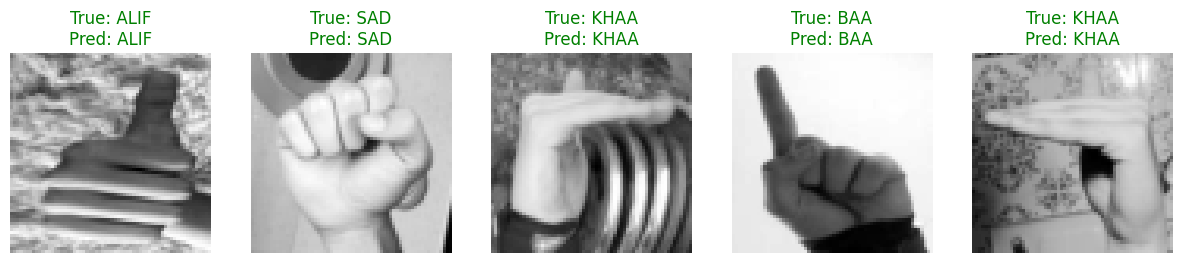

In [ ]:
def show_sample_predictions(model, dataset, classes, num=5):
    model.eval()
    plt.figure(figsize=(15, 4))
    for i in range(num):
        idx = random.randint(0, len(dataset)-1)
        img, label = dataset[idx]
        
        with torch.no_grad():
            out = model(img.unsqueeze(0).to(device))
            _, pred = out.max(1)
            
        plt.subplot(1, num, i+1)
        plt.imshow(img.squeeze(), cmap='gray')
        color = 'green' if pred.item() == label else 'red'
        plt.title(f"True: {classes[label]}\nPred: {classes[pred.item()]}", color=color)
        plt.axis('off')
    plt.show()

show_sample_predictions(model, val_set, classes)

In [8]:
torch.save(model.state_dict(), 'model')
print("Model Saved Successfully!")

Model Saved Successfully!
